In [1]:
import os
import matplotlib.pyplot as plt
import magic
import seaborn as sns
sns.set()

#from sklearn.metrics import roc_curve, roc_auc_score, classification_report, accuracy_score
from sklearn.metrics import accuracy_score
import numpy as np

import sys
import time
repo_root = "../../"
sys.path.append(repo_root)
from models import CompositeClassifier

## Composite preprocessing of adversarial set

In [2]:
adversarial_testset_path = repo_root + "data/adversarial.emulation.dataset/reports_malconv"
adversarial_testset_files = os.listdir(adversarial_testset_path)
adversarial_reports = [x.rstrip(".json") for x in adversarial_testset_files if x.endswith(".json")]
print("Successfull adversarial emulation reports: ", len(adversarial_reports))
adversarial_errors = [x for x in adversarial_testset_files if x.endswith(".err")]
print("Errored adversarial emulation reports: ", len(adversarial_errors))
print("Total adversarial samples: ", len(adversarial_errors) + len(adversarial_reports))
print(f"Emulation success rate: {len(adversarial_reports)/(len(adversarial_reports)+len(adversarial_errors))*100:.2f}%")

Successfull adversarial emulation reports:  4023
Errored adversarial emulation reports:  2864
Total adversarial samples:  6887
Emulation success rate: 58.41%


# NOTE - `6887` total samples because we skipped benignware and malware that was already evasive!

Total file number match with filesystem data:
```
/data/quo.vadis/adversarial/samples_adversarial_testset_gamma_malconv]$ find . -type f | wc -l
6887
```

Adversarial length match with report_db in emulation module - it loads reports from `data/adversarial.emulation.dataset/reports_malconv` since passed as parameter:

In [3]:
a = CompositeClassifier(modules=["emulation"], repo_root=repo_root,
                        emulation_report_path="data/adversarial.emulation.dataset/reports_malconv",)
len(a.modules["emulation"].report_db)

4023

In [4]:
classifier = CompositeClassifier(late_fusion_model="LogisticRegression", repo_root=repo_root,
                                emulation_report_path="data/adversarial.emulation.dataset/reports_malconv",
                                rawpe_db_path="adversarial/samples_adversarial_testset_gamma_malconv")
print(classifier.rawpe_db[adversarial_reports[0]])
print(classifier.modules["emulation"].report_db[adversarial_reports[0]])
classifier.filepath_db[classifier.filepath_db.hash == adversarial_reports[0]]

# preprocess adversarial samples using correct report path
# x_adv_malconv = classifier.preprocess_hashlist(adversarial_reports, dump_xy=True) # takes ~30m

../../adversarial/samples_adversarial_testset_gamma_malconv/812b1ace1c5f2661efd6d450486d70f5b81736519036ee89e7d0b470b64fd415
../../data/adversarial.emulation.dataset/reports_malconv/812b1ace1c5f2661efd6d450486d70f5b81736519036ee89e7d0b470b64fd415.json


,hash,path
9889,812b1ace1c5f2661efd6d450486d70f5b81736519036ee...,C:\Users\user\AppData\Local\Temp\quip.exe


In [5]:
classifier = CompositeClassifier(late_fusion_model="LogisticRegression", repo_root=repo_root)
print(classifier.rawpe_db[adversarial_reports[0]])
print(classifier.modules["emulation"].report_db[adversarial_reports[0]])
classifier.filepath_db[classifier.filepath_db.hash == adversarial_reports[0]]

# preprocess adversarial samples using correct report path
# x_orig_malconv = classifier.preprocess_hashlist(adversarial_reports, dump_xy=True) # takes ~30m

../../data/pe.dataset/PeX86Exe/dropper/812b1ace1c5f2661efd6d450486d70f5b81736519036ee89e7d0b470b64fd415
../../data/emulation.dataset/report_dropper/812b1ace1c5f2661efd6d450486d70f5b81736519036ee89e7d0b470b64fd415.json


,hash,path
9889,812b1ace1c5f2661efd6d450486d70f5b81736519036ee...,C:\Users\user\AppData\Local\Temp\quip.exe


In [38]:
x_adv_malconv = np.load(repo_root+"adversarial/composite_adversarial_evaluation/X-gamma-vs-malconv-early-fusion-pass.arr") 
x_orig_malconv = np.load(repo_root+"adversarial/composite_adversarial_evaluation/X-gamma-vs-malconv-early-fusion-pass-orig.arr")
# python3 run_malconv_pass.py
y_malconv_orig = np.load("y-gamma-vs-malconv-scores-orig.arr")
y_malconv_orig_int = (y_malconv_orig > 0.5).astype(int)
y_malconv_adv = np.load("y-gamma-vs-malconv-scores.arr")
y_malconv_adv_int = (y_malconv_adv > 0.5).astype(int)

x_train = np.load(repo_root+"composite/X-1647041985-early-fusion-vectors-train.arr")
y_train = np.load(repo_root+"composite/y-1647041985-train.arr")

x_test = np.load(repo_root+"composite/X-1647097165-early-fusion-vectors-test.arr")
y_test = np.load(repo_root+"composite/y-1647097165-test.arr")

## Different modules

In [39]:
def fit(models, x_trains, y_train, save=False):
    for model in models:
        print(f"training late fusion model for {model}...")
        now = time.time()
        models[model].fit(x_trains[model], y_train)
        print(f"training done for {model}... took: {time.time()-now:.2f}s")
        if save:
            os.makedirs("late_fusion_model_fit", exist_ok=True)
            models[model].save_late_fusion_model(filename="late_fusion_model_fit/"+model)
    return models

In [41]:
# need to modify report path to original dataset
modulelist = [["ember"], ["filepaths"], ["emulation"], 
            ["ember", "emulation"],
            ["malconv", "emulation"],
            ["malconv", "ember"],
            ["ember", "filepaths", "emulation"],
            ["malconv", "filepaths", "emulation"],
            ["malconv", "ember", "emulation"],
            ["malconv", "ember", "filepaths", "emulation"], ]
models = {}
x_trains = {}
x_tests = {}

x_malconv_orig = {}
x_malconv_adv = {}

for modules in modulelist:
    name = "_".join(modules)
    if len(modules) == 4:
        name = "all"

    models[name] = CompositeClassifier(modules=modules, late_fusion_model="LogisticRegression", repo_root=repo_root)
    x_trains[name] = models[name].get_cropped_x(modules, x_train)
    x_tests[name] = models[name].get_cropped_x(modules, x_test)
    
    x_malconv_orig[name] = models[name].get_cropped_x(modules, x_orig_malconv)
    x_malconv_adv[name] = models[name].get_cropped_x(modules, x_adv_malconv)
    
    if "malconv" in modules:
        # replace 1st column with y
        x_malconv_orig[name][:,0] = y_malconv_orig
        x_malconv_adv[name][:,0] = y_malconv_adv

# Remember: this .fit() really trains only late fusion model
models = fit(models, x_trains, y_train, save=False)

training late fusion model for ember...
training done for ember... took: 0.11s
training late fusion model for filepaths...
training done for filepaths... took: 0.11s
training late fusion model for emulation...
training done for emulation... took: 0.15s
training late fusion model for ember_emulation...
training done for ember_emulation... took: 0.19s
training late fusion model for malconv_emulation...
training done for malconv_emulation... took: 0.14s
training late fusion model for malconv_ember...
training done for malconv_ember... took: 0.15s
training late fusion model for ember_filepaths_emulation...
training done for ember_filepaths_emulation... took: 0.19s
training late fusion model for malconv_filepaths_emulation...
training done for malconv_filepaths_emulation... took: 0.15s
training late fusion model for malconv_ember_emulation...
training done for malconv_ember_emulation... took: 0.14s
training late fusion model for all...
training done for all... took: 0.21s


## Comparing

In [43]:
def get_metrics_adv_nonadv(model, x_test, y_test, x_adv, y_adv):
    probs = model.predict_proba(x_test)[:,1]
    probs_adv = model.predict_proba(x_adv)[:,1]
    
    preds = np.where(probs > 0.5, 1, 0)
    preds_adv = np.where(probs_adv > 0.5, 1, 0)

    print("Non-Adversarial Set accuracy:", end=" ")
    print(accuracy_score(y_test, preds))
    #print(classification_report(y_test, preds, zero_division=0))
    
    print("Adversarial Set accuracy:", end="     ")
    print(accuracy_score(y_adv, preds_adv))
    #print(classification_report(y_adv, preds_adv, zero_division=0))
    return probs, probs_adv

y_adv = np.ones(len(x_adv_malconv))

print("====== malconv ======")
print("Non-Adversarial Set accuracy:", end=" ")
print(accuracy_score(y_adv, y_malconv_orig_int))
print("Adversarial Set accuracy:", end="     ")
print(accuracy_score(y_adv, y_malconv_adv_int))


probbs, probbs_adv = {}, {}
for model in models:
    x_orig_t = x_malconv_orig[model]
    x_adv_t = x_malconv_adv[model]
    print("\n", "="*6, model, "="*6)
    probbs[model], probbs_adv[model] = get_metrics_adv_nonadv(models[model], x_orig_t, y_adv, x_adv_t, y_adv)
    # get_metrics_adv_nonadv(models[model], x_test_t, y_test, x_adv_t, y_adv) if you want against full set

====== malconv ======
Non-Adversarial Set accuracy: 1.0
Adversarial Set accuracy:     0.40939597315436244

 ====== ember ======
Non-Adversarial Set accuracy: 0.927914491672881
Adversarial Set accuracy:     0.8973402933134477

 ====== filepaths ======
Non-Adversarial Set accuracy: 0.9361173253790703
Adversarial Set accuracy:     0.9361173253790703

 ====== emulation ======
Non-Adversarial Set accuracy: 0.9532687049465572
Adversarial Set accuracy:     0.9326373353218991

 ====== ember_emulation ======
Non-Adversarial Set accuracy: 0.9465572955505841
Adversarial Set accuracy:     0.9241859308973402

 ====== malconv_emulation ======
Non-Adversarial Set accuracy: 0.9550086999751429
Adversarial Set accuracy:     0.926671638081034

 ====== malconv_ember ======
Non-Adversarial Set accuracy: 0.9239373601789709
Adversarial Set accuracy:     0.9023117076808352

 ====== ember_filepaths_emulation ======
Non-Adversarial Set accuracy: 0.9445687298036292
Adversarial Set accuracy:     0.942083022619935

In [50]:
print(f" {((y_malconv_orig_int).astype(int) == 0).sum()}: malconv classifies as benign in orig malware set")
print(f" {((y_malconv_adv_int).astype(int) == 0).sum()}: malconv classifies as benign in adversarial malware set")
evasive = ((y_malconv_adv_int).astype(int) == 0).sum() - ((y_malconv_orig_int).astype(int) == 0).sum()
evasive_ratio = evasive*100/len(y_malconv_adv_int)
print(f" {evasive}, {evasive_ratio:.2f}%: evasive samples and ratio against malconv ")
print()

for model in models:
    orig_benign = ((probbs[model] > 0.5).astype(int) == 0).sum()
    adv_benign = ((probbs_adv[model] > 0.5).astype(int) == 0).sum()
    evasive = adv_benign - orig_benign
    evasive_ratio = evasive*100/len(probbs[model])
    print(f" {orig_benign}: {model} classifies as benign in orig malware set")
    print(f" {adv_benign}: {model} classifies as benign in adversarial malware set")
    print(f" {evasive}, {evasive_ratio:.2f}%: evasive samples and ratio against {model} ")
    print()

 0: malconv classifies as benign in orig malware set
 2376: malconv classifies as benign in adversarial malware set
 2376, 59.06%: evasive samples and ratio against malconv 

 290: ember classifies as benign in orig malware set
 413: ember classifies as benign in adversarial malware set
 123, 3.06%: evasive samples and ratio against ember 

 257: filepaths classifies as benign in orig malware set
 257: filepaths classifies as benign in adversarial malware set
 0, 0.00%: evasive samples and ratio against filepaths 

 188: emulation classifies as benign in orig malware set
 271: emulation classifies as benign in adversarial malware set
 83, 2.06%: evasive samples and ratio against emulation 

 215: ember_emulation classifies as benign in orig malware set
 305: ember_emulation classifies as benign in adversarial malware set
 90, 2.24%: evasive samples and ratio against ember_emulation 

 181: malconv_emulation classifies as benign in orig malware set
 295: malconv_emulation classifies as 

# Compare each module separately - adversarial vs non adversarial

## Possible only if - ROC evaluation if forming a validation set with benign latels, but replacing successful adversarial samples

In [88]:
modulelist = [["malconv"], ["ember"], ["emulation"], ["malconv", "ember", "filepaths", "emulation"]]
mmodels = {}
for x in modulelist:
    key = "_".join(x)
    if key == "malconv_ember_filepaths_emulation":
        key = "All"
    mmodels[key] = models[key]

def evaluate_adversarial_robustness(models, x_tests, x_tests_adv, y_test, y_test_adv, ax=None):
    probs = {}
    probs_adv = {}

    model = "No Skill"
    most_common_label = np.argmax(np.bincount(y_test.astype(int)))
    probs[model] = np.array([most_common_label for _ in range(len(y_test))], dtype=int)
    probs_adv[model] = np.array([most_common_label for _ in range(len(y_test_adv))], dtype=int)
    
    _, ax = plt.subplots(2, 2, figsize=(14,12))
    ax_idx = {0: [0,0], 1: [0,1], 2: [1,0], 3:[1,1], 4:[2,0], 5:[2,1]}
    
    for i, model in enumerate(models):
        i1, i2 = ax_idx[i][0],ax_idx[i][1]
        probs[model] = models[model].predict_proba(x_tests[model])[:,1]
        probs_adv[model] = models[model].predict_proba(x_tests_adv[model])[:,1]
        # preds = np.where(probs[model] > 0.5, 1, 0)
        # preds_adv = np.where(probs_adv[model] > 0.5, 1, 0)
        
        fpr, tpr, _ = roc_curve(y_test, probs[model])
        fpr_adv, tpr_adv, _ = roc_curve(y_test_adv, probs_adv[model])
        # plot the roc curve for the model
        linestyle = "--" if model == "No Skill" else "solid"
        ax[i1,i2].plot(fpr, tpr, linestyle=linestyle, label=model)
        ax[i1,i2].plot(fpr_adv, tpr_adv, linestyle=linestyle, label=model)
        # axis labels
        ax[i1,i2].set_xlabel('False Positive Rate')
        ax[i1,i2].set_ylabel('True Positive Rate')
        ax[i1,i2].title.set_text(model)
        _ = ax[i1,i2].legend(["regular", "adversarial"])
        # TBD - set legend position

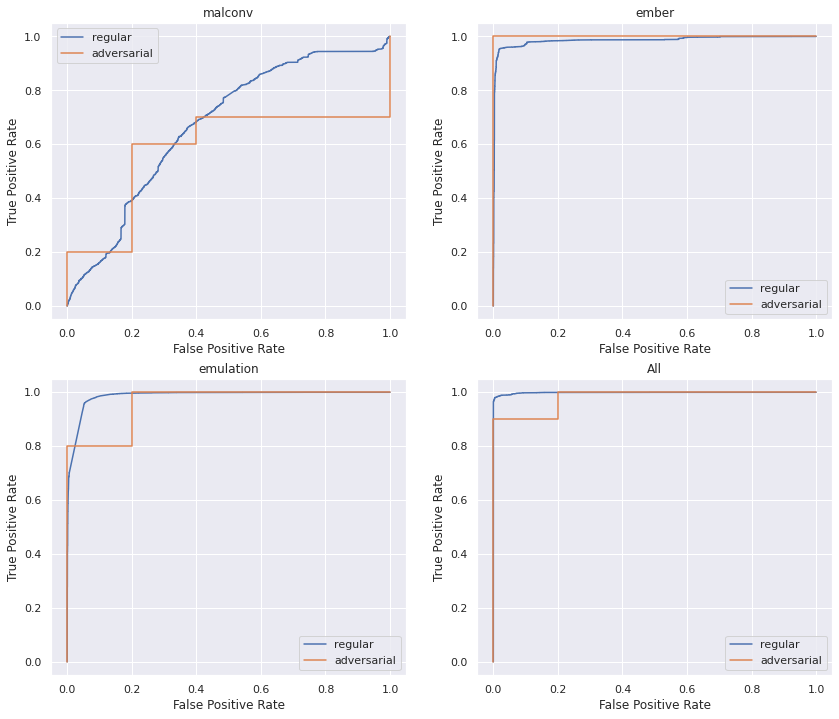

In [89]:
evaluate_adversarial_robustness(mmodels, x_tests, x_tests_adv, y_test, y_test_adv)